# Real singlet extension
This example notebook calculates the trilinear Higgs self coupling in the singlet extended SM and compares with results available in the literatur. The self coupling of the singlet is studied as well.

In [1]:
from anyBSM import anyBSM
from anyBSM.plotting import setAnyStyle
import anyBSM.plotting as plotting
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
setAnyStyle()

In [2]:
# initialize the SSM model shipped with the program
SSM = anyBSM('SSM', quiet=True,progress=False)

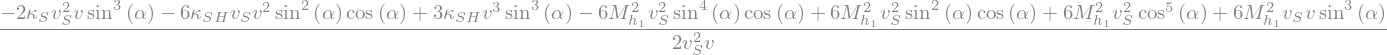

In [3]:
# (re)calculate lambda_hhh in the default (OS) renormalisation scheme 
SSM.clear_cache()
SSM.lambdahhh()
# show hhh tree-level coupling 
SSM.treelevel.simplify().trigsimp().together()

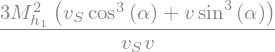

In [11]:
# in the Z2-symmetric case
treez2=SSM.treelevel.subs({SSM.symbols['KapS']:0,SSM.symbols['KapSH']:0}).trigsimp().simplify().together()
treez2

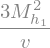

In [12]:
# hhh tree-level coupling for alpha=0
SSM.treelevel.subs({SSM.symbols['alphaH']:0})

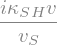

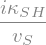

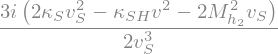

In [13]:
# hSS, hhSS and SSSS tree-level couplings for alpha=0 -> the ratio KapSH/vS being large (i.e. large LamSH) may be interesting
from IPython.display import display
display(SSM.SolveDependencies(SSM.getcoupling('h1','h2','h2')['c'].value,exclude=['vSM'],simplify=True,additional={SSM.symbols['alphaH']:0}))
display(SSM.SolveDependencies(SSM.getcoupling('h1','h1','h2','h2')['c'].value,exclude=['vSM'],simplify=True,additional={SSM.symbols['alphaH']:0}))
display(SSM.SolveDependencies(SSM.getcoupling('h2','h2','h2','h2')['c'].value,exclude=['vSM'],simplify=True,additional={SSM.symbols['alphaH']:0}))

In [3]:
SMtree=187.2818

In [4]:
# iterate over different singlet masses/external momenta
Mh2val = np.linspace(start=180,stop=300,num=20)
p2val = np.linspace(start=250,stop=500,num=100)
SSM.setparameters({'vS': 200,'KapSH': -600,'KapS': 0, 'alphaH':0.0})
lamMh2 = np.array(
    [SSM.lambdahhh(momenta = [125.1**2,125.1**2, 251**2],
                   parameters={'Mh2': m})['total'].real for m in Mh2val]
)
lamp2 = np.array(
    [SSM.lambdahhh(momenta = [125.1**2,125.1**2, p**2],
                   parameters={'Mh2': 200})['total'].real for p in p2val]
)

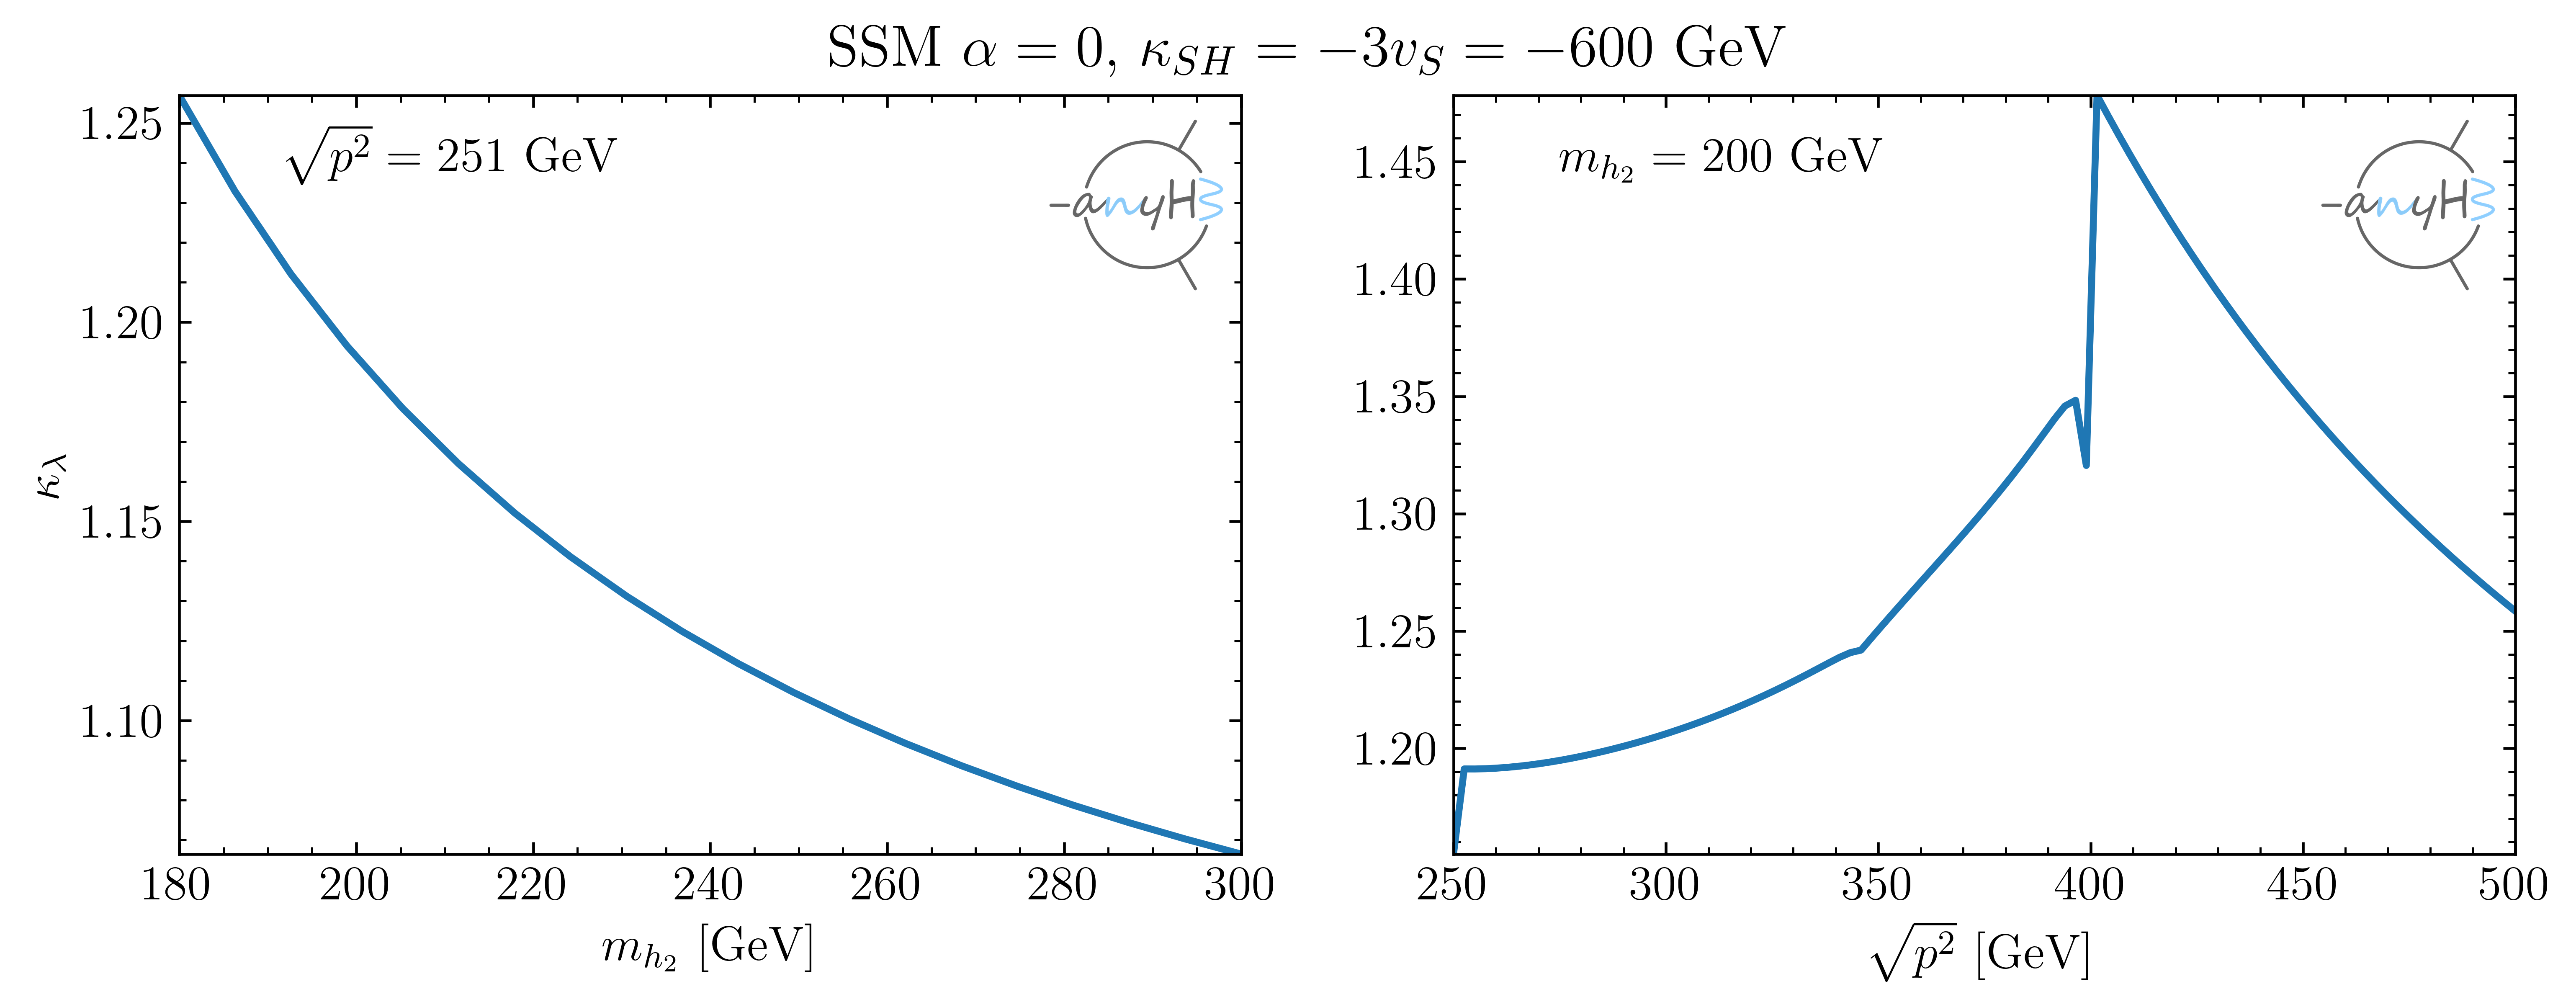

In [33]:
# plot the result, to be compared with https://arxiv.org/abs/1607.04497 Fig.6 and 7 (upper-right)
# note that they use a different VEV (from G_f rather than MZ,MW,alpha(MZ)) as input
# and handle external leg corrections differently (set them OS while we have them MS)
matplotlib.rcParams['font.size']   = 14.0
plotting.anyLogo['show']=False
fig, ax = plt.subplots(1,2,sharex=False,sharey=False, figsize=(12,4))
fig.dpi=600
ax[0].plot(Mh2val, lamMh2/SMtree-0*0.94, lw=2)
ax[0].set_xlim([180,300])
ax[0].margins(0,0)
ax[0].set_xticks([180,200,220,240,260,280,300])

ax[0].annotate(r'$\sqrt{p^2}=251$ GeV',xy=(0.1,0.9),xycoords='axes fraction',)
ax[0].set_xlabel('$m_{h_2}$ [GeV]')
ax[0].set_ylabel(r'$\kappa_\lambda$') #-0.94$')


ax[1].plot(p2val, lamp2/SMtree-0*0.94, lw=2)
ax[1].annotate(r'$m_{h_2}=200$ GeV',xy=(0.1,0.9),xycoords='axes fraction',)
ax[1].set_xlabel('$\sqrt{p^2}$ [GeV]')
ax[1].set_xlim([250,500])
ax[1].margins(0,0)
ax[1].set_xticks([250,300,350,400,450,500])

# ax[1].set_ylabel(r'$\kappa_\lambda$', fontsize=22)
fig.suptitle(r'SSM $\alpha=0$, $\kappa_{SH}=-3v_S =-600$ GeV',y=0.95)

plotting.place_logo(fig,0.767,0.7, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')
plotting.place_logo(fig,0.345,0.7, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')

fig.savefig('SSM_comparison.pdf', bbox_inches='tight',dpi=fig.dpi)
#fig.show()

# Singlet self-coupling $\lambda_{sss}$ in the alignment limit

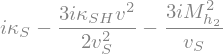

In [17]:
# tree-level coupling for KapS=0,alphaH=0
display(SSM.SolveDependencies(SSM.getcoupling('h2','h2','h2')['c'].value,exclude=['vSM'],simplify=True,additional={SSM.symbols['alphaH']:0}).expand())

In [19]:
SSM.progress = False
SSM.warnSSSS = False
def calcSSS(Mh2,Qren=None):
    if not Qren:
        Qren = (Mh2+SSM.all_parameters['Mu3'])/2
    p = {'Mh2': Mh2,'Qren': Qren}
    SSM.setparameters(p)
    sss=SSM.process('h2','h2','h2')
    a0 = SSM.eigSSSS()
    if a0>0.5:
        print(Mh2, '->',a0)
    # lambda_sss = lambda_sss^{diagrams} - 3 (delta m_s^2)/v_S + 3 m_s^2/v_S (delta v_S)/v_S
    return (-sss['ThreePointTree'].real ,-(
        +sum(sss.values()) 
        + 3*sum(SSM.process('h2','h2').values())/SSM.all_parameters['vS'] 
        - complex(0,-1)*SSM._eval(SSM.Derivative(SSM.getcoupling('h2','h2','h2')['c'].value, 'vS'))*sum(SSM.process('h2').values())/SSM.all_parameters['Mh2']**2).real
    )

In [6]:
# check for scale independence/UV-finiteness for vanishing MSbar couplings
SSM.setparameters({'KapS': 0, 'KapSH': 0,'alphaH':0.0})
q1=calcSSS(300, Qren=1000000)[1]
q2=calcSSS(300, Qren=170)[1]
print(q1-q2)

4.547473508864641e-13


In [20]:
SSM.setparameters({'KapSH': -400,'KapS': 0,'alphaH':0})
mhvals = np.linspace(80,200,50)
SSM.setparameters({'vS': 200})
lamvalsS = np.array(list(map(calcSSS, mhvals))).transpose()
lamvalsSq = np.array([calcSSS(m, SSM.all_parameters['Mu3'])[1] for m in mhvals])

tree=SSM.lambdahhh()['treelevel'].real
lamvals = np.array([SSM.lambdahhh(parameters={'Mh2': m})['total'].real for m in mhvals])

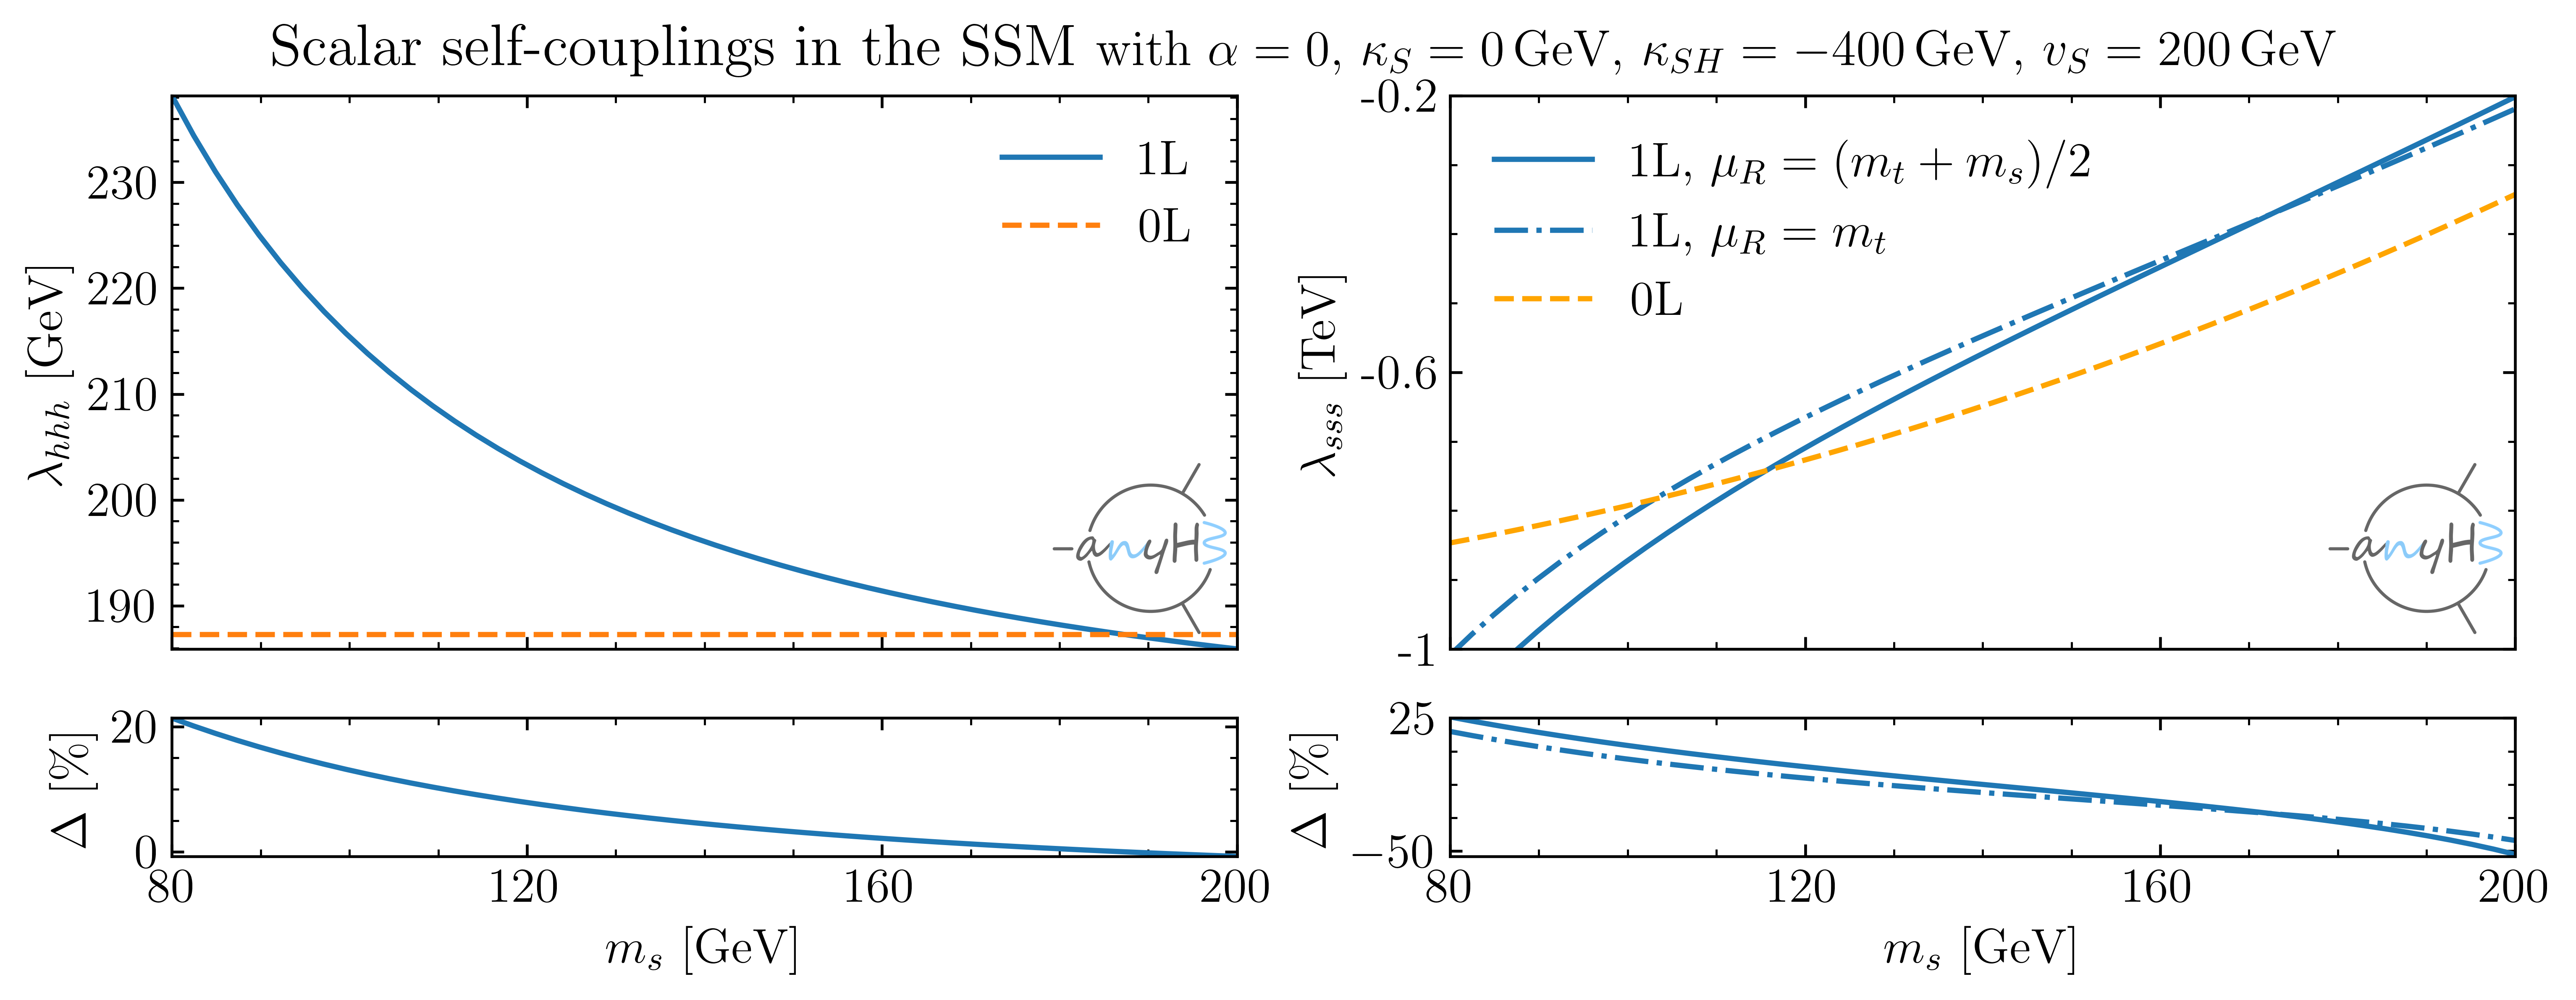

In [29]:
matplotlib.rcParams['font.size']   = 14.0
plotting.anyLogo['show'] = False
fig, ax = plt.subplots(2,2, height_ratios=(0.8,0.2),sharex=True,sharey=False, figsize=(12,4))
fig.dpi=600
ax[0,0].margins(0)
ax[0,0].set_yticks([190,200,210,220,230])
ax[1,0].margins(0)
ax[0,1].plot(mhvals, lamvalsS[1], label='1L, $\mu_R=(m_t+m_s)/2$', c='C0')
ax[0,1].plot(mhvals, lamvalsSq, label='1L, $\mu_R=m_t$', c='C0', ls='-.')
ax[0,1].plot(mhvals, lamvalsS[0], label='0L', ls='--',c='orange')
ax[1,1].set_xlabel('$m_{s}$ [GeV]')
ax[0,1].set_ylabel('$\lambda_{sss}$ [TeV]')
ax[0,1].set_yticks([-1000,-600,-200],[-1,-0.6,-0.2])
ax[0,1].set_ylim(-1000,-200)
ax[1,1].set_yticks([-50,25])
ax[1,1].set_ylim([-53,25])
ax[1,0].set_xticks([80,120,160,200])
ax[0,1].legend(frameon=False, loc='upper left')
ax[1,1].plot(mhvals, 200*(abs(lamvalsS[1])-abs(lamvalsS[0]))/(abs(lamvalsS[1])+abs(lamvalsS[0])), ls='-',c='C0')
ax[1,1].plot(mhvals, 200*(abs(lamvalsSq)-abs(lamvalsS[0]))/(abs(lamvalsSq)+abs(lamvalsS[0])), ls='-.',c='C0')
ax[1,1].set_ylabel(r'$\Delta$ [\%]')
ax[1,0].set_ylabel(r'$\Delta$ [\%]')


ax[0,0].plot(mhvals, lamvals, label='1L')
ax[0,0].plot(mhvals, [tree for m in mhvals],ls='--', label='0L')
ax[1,0].plot(mhvals, 100*(lamvals-tree)/lamvals, ls='-')
ax[0,0].legend(frameon=False, loc='upper right')
ax[0,0].set_ylabel('$\lambda_{hhh}$ [GeV]')
ax[1,0].set_xlabel('$m_{s}$ [GeV]')

fig.suptitle(r'Scalar self-couplings in the SSM {\Large with  $\alpha=0,\, \kappa_{S}=0\,\mathrm{GeV},\, \kappa_{SH}=-400\,\mathrm{GeV},\,v_S=200\,\mathrm{GeV}$}',y=0.95)

plotting.place_logo(fig,0.767,0.35, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')
plotting.place_logo(fig,0.345,0.35, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')

#fig.figimage(plotting.Image.open(plotting.logo_path+'/anyH3logo_v1.png').resize((80,80)),920,150,alpha=0.2)
fig.savefig('SSM_lamsss.pdf', bbox_inches='tight',dpi=fig.dpi)
#fig.show()